In [5]:
# ==============================================================
# XGBoost Classification (XGB) Experiment
# ==============================================================
import pandas as pd
import numpy as np
import sys
import time
from datetime import datetime
import xgboost as xgb  # Make sure you have this installed: pip install xgboost

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)
from preprocessing import prepare_data

# Experiment config
random_state = 42
results = []
partial_save_path = "results/xgb_partial_results.csv"

In [6]:
# ---
# 1. Load Data
# ---
train_df = pd.read_csv("fraudTrain.csv")
test_df = pd.read_csv("fraudTest.csv")

print("Loaded train/test data.")

Loaded train/test data.


In [7]:
# ---
# 2. Prepare Data for TREE Models
# ---
# We MUST use mode="tree". This skips scaling and uses OrdinalEncoders.
out_train_init = prepare_data(
    train_df,
    mode="tree",
    training=False,  # We only need the encoders
    fit=True,
)
encoders = out_train_init["encoders"]
scalers = {}  # Scalers are not used

# Prepare TEST set using the *same* "tree" mode
out_test = prepare_data(
    test_df,
    mode="tree",
    training=False,
    fit=False,
    encoders=encoders,
    scalers=scalers,
)
df_test = out_test["df"]
X_test = df_test.drop("is_fraud", axis=1)
y_test = df_test["is_fraud"]

# Clean inf/-inf values
X_test = X_test.replace([np.inf, -np.inf], np.nan).fillna(0).clip(-1e6, 1e6)

print(f"Test set prepared for trees. Shape: {X_test.shape}")

Test set prepared for trees. Shape: (555719, 13)


In [8]:
# ---
# 3. Define Experiment Parameters
# ---
# Based on ALL previous results, we are only testing the best ratios.
ratios_to_test = [0.05, 0.1, 0.2] 
resample_types_to_test = ["df_up", "df_down"] 

# XGBoost specific parameters
# 'scale_pos_weight' is how XGBoost handles imbalance *internally*.
# We will test both our external resampling (what we've been doing)
# and its internal method.
params_to_test = [
    {
        "name": "XGB_Resampled", # Our method
        "params": {
            "n_estimators": 200, # More trees
            "max_depth": 10,       # Based on RF, deep trees are fine
            "learning_rate": 0.1,
            "objective": "binary:logistic",
            "eval_metric": "logloss",
            "n_jobs": -1,
            "random_state": random_state,
            "scale_pos_weight": 1 # <-- We are handling balance with resampling
        },
    },
]

In [9]:
# ---
# 4. Run Experiment Loop
# ---
print("\nStarting XGBoost experiment loop...")
for ratio_idx, ratio in enumerate(ratios_to_test, start=1):
    print(f"\n{'='*70}")
    print(
        f"[{datetime.now().strftime('%H:%M:%S')}] Starting ratio {ratio_idx}/{len(ratios_to_test)} → ratio={ratio}"
    )
    start_ratio_time = time.time()

    out_train = prepare_data(
        train_df,
        mode="tree",
        training=True,
        ratio=ratio,
        fit=False,  
        encoders=encoders,
        scalers=scalers,
    )

    for resample_type in resample_types_to_test:
        if resample_type not in out_train or out_train[resample_type] is None:
            continue

        df_train = out_train[resample_type]
        X_train = df_train.drop("is_fraud", axis=1)
        y_train = df_train["is_fraud"]

        X_train = X_train.replace([np.inf, -np.inf], np.nan).fillna(0).clip(-1e6, 1e6)

        print(
            f"  [{datetime.now().strftime('%H:%M:%S')}] → Training on {resample_type} (samples={len(X_train):,})"
        )
        sys.stdout.flush()

        for p_info in params_to_test:
            model_name = p_info["name"]
            params = p_info["params"]
            start_k_time = time.time()

            print(f"    ⏳ Running {model_name} ...", end="")
            sys.stdout.flush()

            model = xgb.XGBClassifier(**params)
            
            model.fit(
                X_train, 
                y_train,
                eval_set=[(X_test, y_test)],
                verbose=False
            )

            # Predict
            y_pred = model.predict(X_test)
            y_prob = model.predict_proba(X_test)[:, 1]

            # Metrics
            f1 = f1_score(y_test, y_pred)
            rec = recall_score(y_test, y_pred)
            auc = roc_auc_score(y_test, y_prob)
            prec = precision_score(y_test, y_pred)
            acc = accuracy_score(y_test, y_pred)

            # === FIX #1: Handle AttributeError ===
            try:
                best_iter = model.best_iteration
            except AttributeError:
                best_iter = model.n_estimators # Set to full run if no early stop
            # =====================================

            results.append(
                {
                    "model": model_name,
                    "ratio": ratio,
                    "resample_type": resample_type.replace("df_",""),
                    "accuracy": acc,
                    "precision": prec,
                    "recall": rec,
                    "f1": f1,
                    "roc_auc": auc,
                    "best_iter": best_iter
                }
            )

            print(
                f" done → F1={f1:.4f}, Recall={rec:.4f}, AUC={auc:.4f} | Time={time.time() - start_k_time:.1f}s"
            )
            sys.stdout.flush()

    pd.DataFrame(results).to_csv(partial_save_path, index=False)
    print(f"  💾 Saved intermediate results → {partial_save_path}")
    print(f"  ✅ Completed ratio={ratio} in {(time.time() - start_ratio_time)/60:.1f} min")


Starting XGBoost experiment loop...

[23:58:01] Starting ratio 1/3 → ratio=0.05
  [23:58:03] → Training on df_up (samples=1,353,627)
    ⏳ Running XGB_Resampled ... done → F1=0.8469, Recall=0.7841, AUC=0.9973 | Time=28.4s
  [23:58:32] → Training on df_down (samples=157,626)
    ⏳ Running XGB_Resampled ... done → F1=0.7645, Recall=0.8587, AUC=0.9973 | Time=7.2s
  💾 Saved intermediate results → results/xgb_partial_results.csv
  ✅ Completed ratio=0.05 in 0.6 min

[23:58:39] Starting ratio 2/3 → ratio=0.1
  [23:58:42] → Training on df_up (samples=1,418,086)
    ⏳ Running XGB_Resampled ... done → F1=0.8513, Recall=0.7991, AUC=0.9967 | Time=30.2s
  [23:59:12] → Training on df_down (samples=82,566)
    ⏳ Running XGB_Resampled ... done → F1=0.6367, Recall=0.9049, AUC=0.9973 | Time=4.6s
  💾 Saved intermediate results → results/xgb_partial_results.csv
  ✅ Completed ratio=0.1 in 0.6 min

[23:59:16] Starting ratio 3/3 → ratio=0.2
  [23:59:19] → Training on df_up (samples=1,547,003)
    ⏳ Running 

In [10]:
# ---
# 5. Add the "Internal Resampling" Experiment (API FIX)
# ---
print(f"\n{'='*70}")
print(f"[{datetime.now().strftime('%H:%M:%S')}] Starting Internal Imbalance Handling (scale_pos_weight)")
start_ratio_time = time.time()

out_train_orig = prepare_data(
    train_df,
    mode="tree",
    training=True,
    ratio=None, 
    fit=False,  
    encoders=encoders,
    scalers=scalers,
)

df_train_orig = out_train_orig["df_up"] 
X_train_orig = df_train_orig.drop("is_fraud", axis=1)
y_train_orig = df_train_orig["is_fraud"]

X_train_orig = X_train_orig.replace([np.inf, -np.inf], np.nan).fillna(0).clip(-1e6, 1e6)

n_legit = (y_train_orig == 0).sum()
n_fraud = (y_train_orig == 1).sum()
imbalance_ratio = n_legit / n_fraud
print(f"  Using original training data (samples={len(X_train_orig):,})")
print(f"  Calculated scale_pos_weight: {imbalance_ratio:.2f} (Legit: {n_legit}, Fraud: {n_fraud})")
sys.stdout.flush()

model_name = "XGB_Internal_ScalePos"
# === API FIX: MOVED PARAMS HERE ===
params = {
    "n_estimators": 200,
    "max_depth": 10,
    "learning_rate": 0.1,
    "objective": "binary:logistic",
    "n_jobs": -1,
    "random_state": random_state,
    "scale_pos_weight": imbalance_ratio,
    "early_stopping_rounds": 20,
    "eval_metric": "logloss"
}

start_k_time = time.time()
print(f"    ⏳ Running {model_name} ...", end="")
sys.stdout.flush()

model = xgb.XGBClassifier(**params)
# === API FIX: Removed early_stopping_rounds from .fit() ===
model.fit(
    X_train_orig, 
    y_train_orig,
    eval_set=[(X_test, y_test)],
    verbose=False
)

# Predict & Metrics
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]
f1 = f1_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)
prec = precision_score(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)

results.append(
    {
        "model": model_name,
        "ratio": "internal", 
        "resample_type": "none",
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc": auc,
        # === API FIX: Use .best_iteration attribute ===
        "best_iter": model.best_iteration
    }
)
print(
    f" done → F1={f1:.4f}, Recall={rec:.4f}, AUC={auc:.4f} | Time={time.time() - start_k_time:.1f}s"
)
print(f"  💾 Saved intermediate results → {partial_save_path}")
print(f"  ✅ Completed internal run in {(time.time() - start_ratio_time)/60:.1f} min")


[23:59:56] Starting Internal Imbalance Handling (scale_pos_weight)
  Using original training data (samples=1,296,675)
  Calculated scale_pos_weight: 171.75 (Legit: 1289169, Fraud: 7506)
    ⏳ Running XGB_Internal_ScalePos ... done → F1=0.8088, Recall=0.8107, AUC=0.9960 | Time=22.6s
  💾 Saved intermediate results → results/xgb_partial_results.csv
  ✅ Completed internal run in 0.4 min


In [11]:
# ---
# 6. Show Final Results
# ---
print("\nAll ratios completed.")
print(f"Total experiments logged: {len(results)}")
results_df = pd.DataFrame(results).sort_values(by="f1", ascending=False)
print("\n--- Top Performing XGBoost Models ---")
print(results_df.head(10))

results_df.to_csv("results/xgb_results.csv", index=False)
print("\nSaved final results to results/xgb_results.csv")


All ratios completed.
Total experiments logged: 7

--- Top Performing XGBoost Models ---
                   model     ratio resample_type  accuracy  precision  \
2          XGB_Resampled       0.1            up  0.998922   0.910733   
0          XGB_Resampled      0.05            up  0.998906   0.920635   
4          XGB_Resampled       0.2            up  0.998845   0.887571   
6  XGB_Internal_ScalePos  internal          none  0.998521   0.806961   
1          XGB_Resampled      0.05          down  0.997958   0.688856   
3          XGB_Resampled       0.1          down  0.996014   0.491144   
5          XGB_Resampled       0.2          down  0.992912   0.345505   

     recall        f1   roc_auc  best_iter  
2  0.799068  0.851254  0.996673        200  
0  0.784149  0.846928  0.997278        200  
4  0.802331  0.842801  0.996967        200  
6  0.810723  0.808837  0.996021        199  
1  0.858741  0.764474  0.997260        200  
3  0.904895  0.636707  0.997298        200  
5  0.93519


Generating plots...


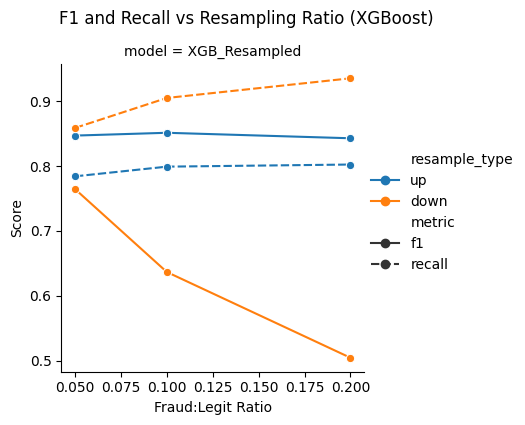

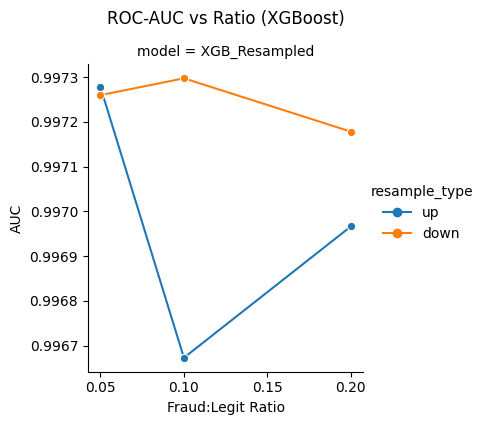


--- Mean Scores Summary ---
                                              precision  recall     f1  \
model                 ratio    resample_type                             
XGB_Internal_ScalePos internal none               0.807   0.811  0.809   
XGB_Resampled         0.05     down               0.689   0.859  0.764   
                               up                 0.921   0.784  0.847   
                      0.1      down               0.491   0.905  0.637   
                               up                 0.911   0.799  0.851   
                      0.2      down               0.346   0.935  0.505   
                               up                 0.888   0.802  0.843   

                                              roc_auc  
model                 ratio    resample_type           
XGB_Internal_ScalePos internal none             0.996  
XGB_Resampled         0.05     down             0.997  
                               up               0.997  
                      0.

In [12]:
# ---
# 7. Plot Results
# ---

# Add these imports to Cell 1
import matplotlib.pyplot as plt
import seaborn as sns

if not results_df.empty:
    print("\nGenerating plots...")
    
    # ---- Plot F1 & Recall vs Ratio (faceted by model) ----
    
    # Filter out the 'internal' ratio for this plot, it messes up the x-axis
    plot_df = results_df[results_df['ratio'] != 'internal'].copy()
    plot_df['ratio'] = plot_df['ratio'].astype(float)
    
    # Melt for easier plotting
    df_melt = plot_df.melt(id_vars=['ratio', 'resample_type', 'model'], 
                           value_vars=['f1', 'recall'],
                           var_name='metric', value_name='score')

    # Use sns.relplot()
    g_f1 = sns.relplot(
        data=df_melt,
        x="ratio",
        y="score",
        hue="resample_type",
        style="metric",
        col="model",
        kind="line",
        marker="o",
        height=4,
        aspect=1
    )
    g_f1.fig.suptitle("F1 and Recall vs Resampling Ratio (XGBoost)", y=1.05)
    g_f1.set_axis_labels("Fraud:Legit Ratio", "Score")
    g_f1.savefig("results/xgb_f1_recall_plot.png")
    plt.show()

    # ---- Plot ROC-AUC vs Ratio (faceted by model) ----
    
    g_auc = sns.relplot(
        data=plot_df,
        x="ratio",
        y="roc_auc",
        hue="resample_type",
        col="model",
        kind="line",
        marker="o",
        height=4,
        aspect=1
    )
    g_auc.fig.suptitle("ROC-AUC vs Ratio (XGBoost)", y=1.05)
    g_auc.set_axis_labels("Fraud:Legit Ratio", "AUC")
    g_auc.savefig("results/xgb_auc_plot.png")
    plt.show()
    
    # ---- Summary Table ----
    summary = results_df.groupby(["model", "ratio", "resample_type"])[["precision", "recall", "f1", "roc_auc"]].mean().round(3)
    print("\n--- Mean Scores Summary ---")
    print(summary)

    print("\nPlots and summary complete.")
else:
    print("No results to plot.")